In [2]:
import sklearn
assert sklearn.__version__=='0.23.2', 'Posible problema de version en sklearn'

## Importación de librerías

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from scipy.io import arff
import random
from collections import OrderedDict
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve
## sklearn-optimize es tomado de: https://github.com/senolakkas/sklearn-optimize
from sklearn_genetic.genetic import GeneticSearchCV
from deap import base, creator, tools, algorithms
from sklearn.base import clone, is_classifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib
from tabulate import tabulate
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [6]:
# GeneticSearchCV modificado
class GeneticSearchCVMod(GeneticSearchCV):
     def __init__(self, estimator, params, scoring=None, cv=4,
                 refit=True, verbose=False, population_size=50,
                 gene_mutation_prob=0.1, gene_crossover_prob=0.5,
                 tournament_size=3, generations_number=10, gene_type=None,
                 n_jobs=1, iid=True, error_score='raise',
                 fit_params={}):
        super(GeneticSearchCV, self).__init__(
            estimator=estimator, scoring=scoring,
            iid=iid, refit=refit, cv=cv, verbose=verbose,
            error_score=error_score)
        self.fit_params=fit_params
        self.params = params
        self.population_size = population_size
        self.generations_number = generations_number
        self._individual_evals = {}
        self.gene_mutation_prob = gene_mutation_prob
        self.gene_crossover_prob = gene_crossover_prob
        self.tournament_size = tournament_size
        self.gene_type = gene_type
        self.all_history_, self.all_logbooks_ = [], []
        self._cv_results = None
        self.best_score_ = None
        self.best_params_ = None
        self.score_cache = {}
        self.n_jobs = n_jobs
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, est=clone(self.estimator), fitness=creator.FitnessMax)

## Lectura de modelos guardados

In [7]:
param_ga = {"kernel": ["rbf", "sigmoid", "linear"],
             "C": np.logspace(-2, 2, num=10, base=10),
             "gamma": np.logspace(-2, 2, num=10, base=10)}
cv_svm_ga_model = GeneticSearchCVMod(estimator=SVC(probability=True),
                     params=param_ga,
                     scoring="recall",
                     cv=5,
                     verbose=1,
                     population_size=20,
                     gene_mutation_prob=0.10,
                     gene_crossover_prob=0.5,
                     tournament_size=3,
                     generations_number=5,
                     n_jobs=4)

In [9]:
# cargamos los modelos
dt_model = joblib.load(os.path.join('modelos','Modelo_DT.pkl'))
lr_model = joblib.load(os.path.join('modelos','Modelo_LR.pkl'))
rf_model = joblib.load(os.path.join('modelos','Modelo_RF.pkl'))
xgb_model = joblib.load(os.path.join('modelos','Modelo_XGB.pkl'))
cv_svm_model = joblib.load(os.path.join('modelos','Modelo_SVM.pkl'))
svm_model = cv_svm_model.best_estimator_
cs_svm_ga_model = joblib.load(os.path.join('modelos','Modelo_GA_SVM.pkl'))
svm_ga_model = cs_svm_ga_model.best_estimator_

## Lectura de dataset imputado

In [10]:
# se carga dataset imputado
imputed_df = pd.read_pickle(os.path.join('results','dataset_normalizado.pkl'))

In [30]:
# función para separar las columnas en variables y etiquetas ('flag')
def split_features_labels(df):
    feature_dfs = df.iloc[:, :-1]
    label_dfs = df['flag']
    return feature_dfs, label_dfs

## Evaluación de modelos

In [34]:
def save_and_show_resultados(descripcion, model, resultados, X_train, X_test, y_train, y_test):
  y_train_pred = model.predict(X_train)
  y_train_pred_proba = model.predict_proba(X_train)[:,1]

  y_test_pred = model.predict(X_test)
  y_test_pred_proba = model.predict_proba(X_test)[:,1]

  confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
  confusion_matrix_test = confusion_matrix(y_test, y_test_pred)

  resultados.update( { descripcion: {
      ('Entrenamiento', 'Exactitud'): model.score(X_train, y_train),
      ('Entrenamiento', 'Exhaustividad'): recall_score(y_train, y_train_pred),
      ('Entrenamiento', 'F1'): f1_score(y_train, y_train_pred),
      ('Entrenamiento', 'AUC'): roc_auc_score(y_train, y_train_pred_proba),
      ('Entrenamiento', 'TypeI'): confusion_matrix_train[0][1],
      ('Pruebas', 'Exactitud'): model.score(X_test, y_test),
      ('Pruebas', 'Exhaustividad'): recall_score(y_test, y_test_pred),
      ('Pruebas', 'F1'): f1_score(y_test, y_test_pred),
      ('Pruebas', 'AUC'): roc_auc_score(y_test, y_test_pred_proba),
      ('Pruebas', 'TypeI'): confusion_matrix_test[0][1]
    } } )
  fig, axes = plt.subplots(1, 3, figsize=(18, 5))
  fig.suptitle(f'{descripcion} (Conjunto de Pruebas)')
  plot_confusion_matrix(model, X_test, y_test, ax=axes[0], values_format='d')
  plot_roc_curve(model, X_test, y_test, ax=axes[1], name=descripcion)
  plot_precision_recall_curve(model, X_test, y_test, ax=axes[2], name=descripcion)
  return

In [13]:
def tabla_resultados(resultados):
  df = pd.DataFrame.from_dict(resultados, orient='index')
  display(df)
  return df

In [32]:
# Modelamiento de la data usando un diccionario de datasets y modelos
def perform_data_evaluation(modelos, imputed_df):
    # to show table
    resultados = {}

    # hacemos la division del dataframe en variables y etiquetas
    X, y = split_features_labels(imputed_df)

    # Dividimos la data en test y train
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    test_size = 0.2,
                                                    random_state = 1)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,test_size = 0.2,random_state=1)
    # Iteramos sobre los clasificadores
    for model_name, clf in modelos.items():
       
        # actualiza resultados
        save_and_show_resultados(model_name, clf, resultados, X_train, X_test, y_train, y_test)

    # presentamos la tabla resumen
    tabla_results = tabla_resultados(resultados)

    return tabla_results

## Análisis comparativo

In [21]:
# models
models_dictionary2 = OrderedDict()
models_dictionary2['SVM'] = svm_model
models_dictionary2['SVM+GA'] = svm_ga_model
models_dictionary2['DT'] = dt_model
models_dictionary2['LR'] = lr_model
models_dictionary2['RF'] = rf_model
models_dictionary2['XGB'] = xgb_model

In [17]:
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=9, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=85, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

**Comparación**

Entrenamiento                             Pruebas                      \
           Exactitud        F1       AUC TypeI Exactitud        F1       AUC   
SVM         0.839780  0.004556  0.238697   700  0.839443  0.000000  0.218853   
SVM+GA      0.825115  0.004175  0.164306   780  0.823314  0.000000  0.148502   
DT          0.972869  0.383333  0.951310    18  0.968475  0.271186  0.885158   
LR          0.972869  0.383333  0.951310    18  0.968475  0.271186  0.885158   
RF          0.970302  0.147368  0.955495     0  0.969208  0.086957  0.940771   
XGB         1.000000  1.000000  1.000000     0  0.972141  0.344828  0.923192   

              
       TypeI  
SVM      175  
SVM+GA   197  
DT         7  
LR         7  
RF         0  
XGB        4

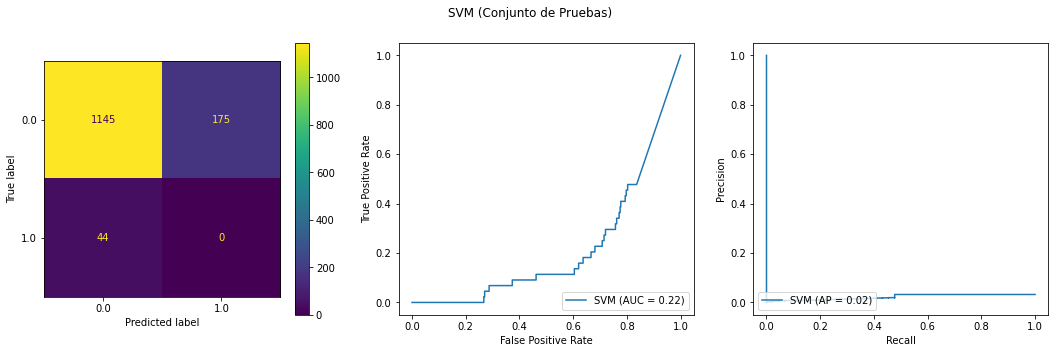

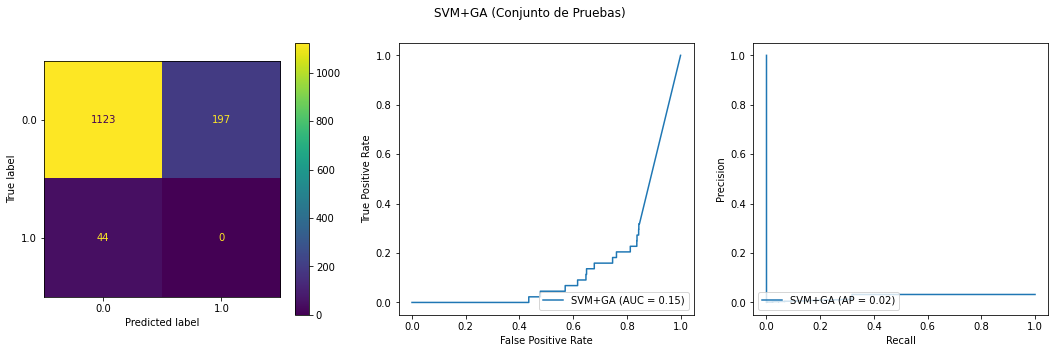

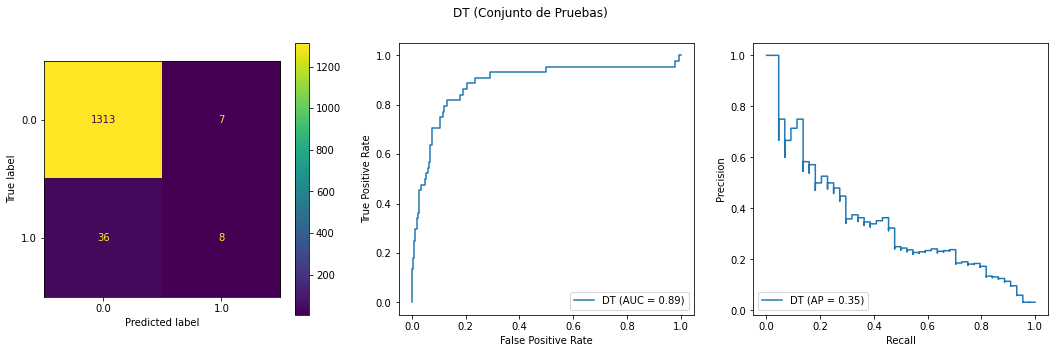

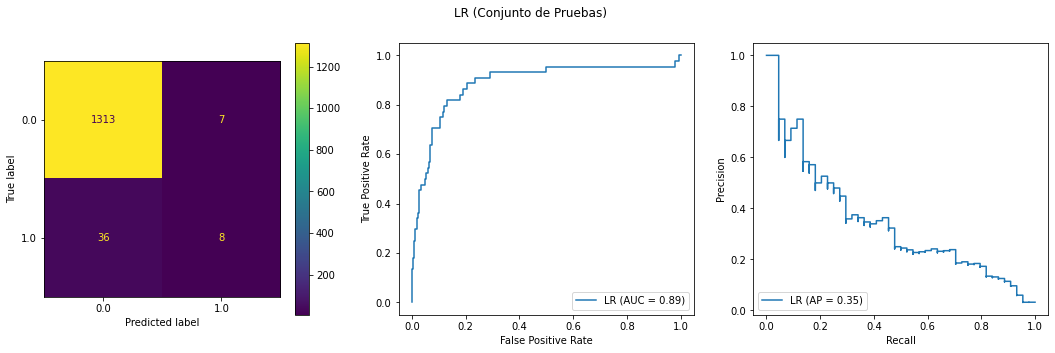

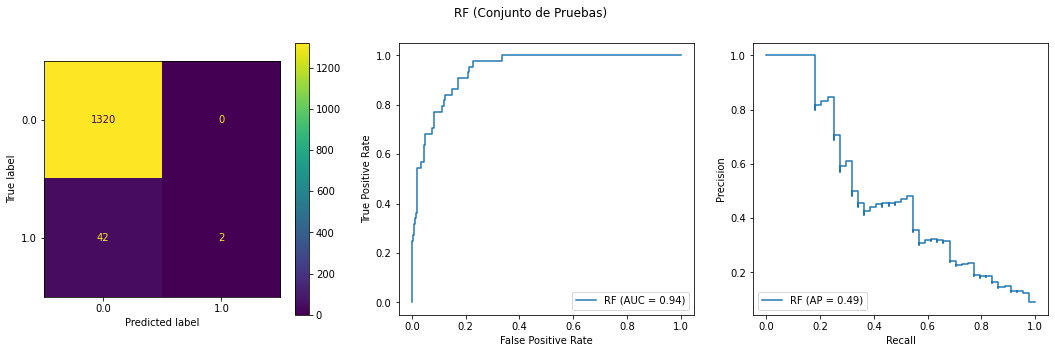

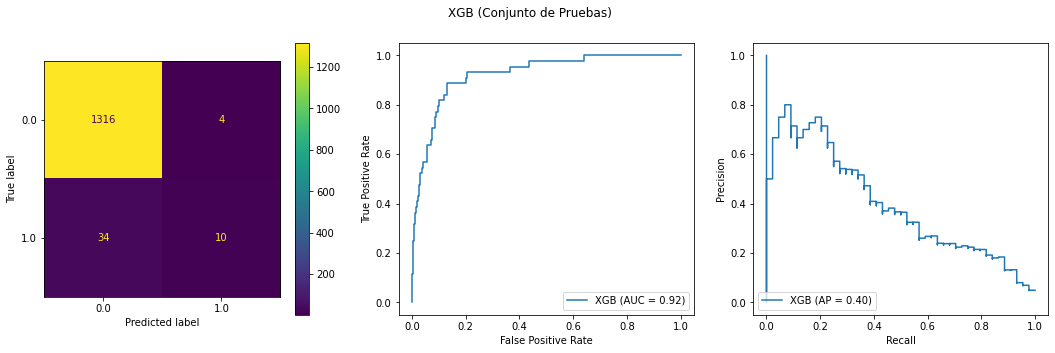

In [33]:
# Verificamos validación para comparación
metricas = perform_data_evaluation(models_dictionary2, imputed_df)

**Tablas**

In [26]:
print(metricas.to_latex(index=False))  

\begin{tabular}{rrrrrrrr}
\toprule
Entrenamiento & \multicolumn{4}{l}{Pruebas} \\
    Exactitud &       F1 &      AUC & TypeI & Exactitud &       F1 &      AUC & TypeI \\
\midrule
     0.839780 & 0.004556 & 0.238697 &   700 &  0.839443 & 0.000000 & 0.218853 &   175 \\
     0.825115 & 0.004175 & 0.164306 &   780 &  0.823314 & 0.000000 & 0.148502 &   197 \\
     0.972869 & 0.383333 & 0.951310 &    18 &  0.968475 & 0.271186 & 0.885158 &     7 \\
     0.972869 & 0.383333 & 0.951310 &    18 &  0.968475 & 0.271186 & 0.885158 &     7 \\
     0.970302 & 0.147368 & 0.955495 &     0 &  0.969208 & 0.086957 & 0.940771 &     0 \\
     1.000000 & 1.000000 & 1.000000 &     0 &  0.972141 & 0.344828 & 0.923192 &     4 \\
\bottomrule
\end{tabular}



## Producción de gráficos

<AxesSubplot:title={'center':'Exactitud'}>

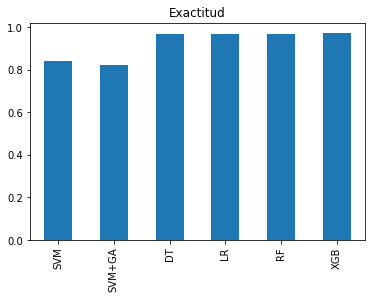

In [27]:
metricas.unstack()['Pruebas']['Exactitud'].plot(kind='bar',title='Exactitud')

<AxesSubplot:title={'center':'F1-score'}>

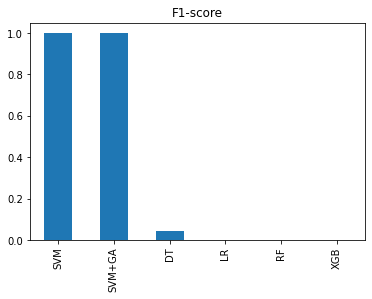

In [59]:
metricas.unstack()['Pruebas']['F1'].plot(kind='bar',title='F1-score')

<AxesSubplot:title={'center':'AUC'}>

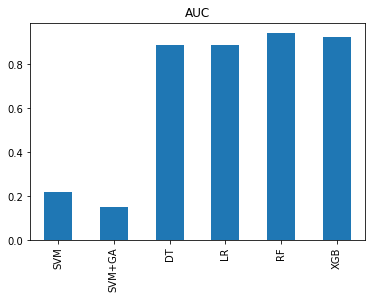

In [28]:
metricas.unstack()['Pruebas']['AUC'].plot(kind='bar',title='AUC')

<AxesSubplot:title={'center':'Type I'}>

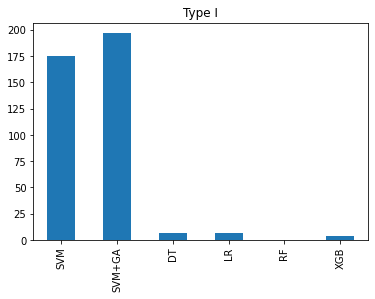

In [29]:
metricas.unstack()['Pruebas']['TypeI'].plot(kind='bar',title='Type I')